In [1]:
import pandas as pd
import geopandas as gpd
import subprocess
import numpy as np
import shapely.geometry as shpg
import os
import sys
import json
import logging

In [2]:
sys.path.append(os.getcwd() + '/../..')
from utils import mkdir, open_zip_shapefile, open_tar_shapefile, haversine

In [3]:
log = logging.getLogger('papermill')
logging.basicConfig(level='INFO', format="%(message)s")

## Files and storage paths

In [4]:
# Region of interest
reg = 3

# go down from rgi7_scripts/workflow
data_dir = '../../../../rgi7_data/'

# Input dirctory
input_dir_tar = os.path.join(data_dir, 'l4_rgi7b0_tar')
input_dir = os.path.join(data_dir, 'l4_rgi7b0')

### Load the input data

In [5]:
reg_file = os.path.join(data_dir, '00_rgi70_regions', '00_rgi70_O1Regions')
reg_file = gpd.read_file(reg_file)
fname = reg_file.loc[reg_file['o1region'] == f'{reg:02d}'].iloc[0]['long_code']

In [6]:
# Read beta files
shp = open_tar_shapefile(input_dir_tar + f'/RGI2000-v7.0-G-{fname}.tar.gz')
odf_subm = pd.read_csv(input_dir + f'/RGI2000-v7.0-G-{fname}/RGI2000-v7.0-G-{fname}_subm_info.csv', index_col=0)

VSIFSeekL(xxx, SEEK_END) may be really slow on GZip streams.


## Printouts for docs 

In [62]:
for i, line in odf_subm.iterrows():
    print(f"Submission {i}")
    print(f": **Submitter**: {line['submitters']} ({line['chief_affl']})."
          f"<br/>**Number of outlines**: {line['n_outlines']}. **Area**: {line['area_km2']:.1f}km². **Release date**: {line['release_dt'][:10]}."
          f"<br/>**Analysts**: {line['analysts']}.")
    print(f"")

Submission 590
: **Submitter**: Bolch, Tobias (University of Colorado).<br/>**Number of outlines**: 653. **Area**: 39842.3km². **Release date**: 2015-07-15.<br/>**Analysts**: Barrand, Nick; Burgess, Dave; Cawkwell, Fiona; Copland, Luke; Filbert, Katie; Gardner, Alex; Hartmann, G; OCallaghan, P; Paul, Frank; Sharp, Martin; Wolken, G.; Wyatt, F..

Submission 635
: **Submitter**: Cogley, Graham (University of Colorado).<br/>**Number of outlines**: 7. **Area**: 128.2km². **Release date**: 2015-07-16.<br/>**Analysts**: Berthier, Etienne; Bolch, Tobias; Cogley, Graham; Kienholz, Christian.

Submission 723
: **Submitter**: Paul, Frank (University of Zurich-Irchel).<br/>**Number of outlines**: 2583. **Area**: 27691.6km². **Release date**: 2021-09-03.<br/>**Analysts**: Paul, Frank; Rastner, Philipp; White, Adrienne.

Submission 728
: **Submitter**: Kochtitzky, William (University of Alberta).<br/>**Number of outlines**: 1961. **Area**: 37675.5km². **Release date**: 2021-08-27.<br/>**Analysts**:

In [8]:
odf_subm

,n_outlines,area_km2,anlys_time,release_dt,proc_desc,chief_affl,submitters,analysts,rc_id
subm_id,,,,,,,,,
616,33,1.111895,2016-04-15T00:00:00,2016-07-26T09:00:00,Manual delineation of glacier boundaries,Portland State University,"Hoffman, Matthew","Fountain, Andrew G.; Hoffman, Matthew",5
623,12463,13054.772704,2008-05-01T00:00:00,2009-06-27T00:10:31,An existing ice polygon layer from a provincia...,University of Northern British Columbia,"Bolch, Tobias","Bolch, Tobias",536
635,1235,656.531784,2015-07-16T00:00:00,2015-07-16T00:00:00,Semi-automated glacier classification.; From R...,University of Colorado,"Cogley, Graham","Berthier, Etienne; Bolch, Tobias; Cogley, Grah...",761
721,1,136.850031,2008-05-01T00:00:00,2009-06-27T00:10:31,An existing ice polygon layer from a provincia...,University of Northern British Columbia,"Bolch, Tobias","Bolch, Tobias",536
722,1,10.196873,2008-05-01T00:00:00,2009-06-27T00:10:31,An existing ice polygon layer from a provincia...,University of Northern British Columbia,"Bolch, Tobias","Bolch, Tobias",536
744,5126,671.422854,2006-08-01T00:00:00,2016-02-26T09:00:00,Digitization from 1:24000 maps (24K) published...,Portland State University,"Fountain, Andrew G.","Fountain, Andrew G.",5


## Maps 

In [8]:
import salem
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
from matplotlib.image import imread
import seaborn as sns

In [9]:
rdf = salem.read_shapefile(os.path.join(data_dir, '00_rgi70_regions', '00_rgi70_O1Regions', '00_rgi70_O1Regions.shp'))
srdf = salem.read_shapefile(os.path.join(data_dir, '00_rgi70_regions', '00_rgi70_O2Regions', '00_rgi70_O2Regions.shp'))

rdf = rdf.loc[rdf['o1region'] == f'{reg:02d}']
srdf = srdf.loc[srdf['o1region'] == f'{reg:02d}']

In [10]:
extent = [rdf.min_x.iloc[0], rdf.max_x.iloc[0], rdf.min_y.iloc[0], rdf.max_y.iloc[0]]
extent

[-125.000000000415, -59.9999999996562, 74.0, 84.9999999999418]

In [52]:
extent = [-123, -76.0, 72.0, 86.0]

In [53]:
map_crs = ccrs.LambertConformal(
    central_longitude=(extent[0] + extent[1]) / 2,
    central_latitude=(extent[2] + extent[3]) / 2,
    standard_parallels=(76, 82),
)

In [55]:
shp_repr = shp.to_crs(map_crs)

N=653, A=39842.3 km²
N=7, A=128.2 km²
N=2583, A=27691.6 km²
N=1961, A=37675.5 km²
N=23, A=33.9 km²


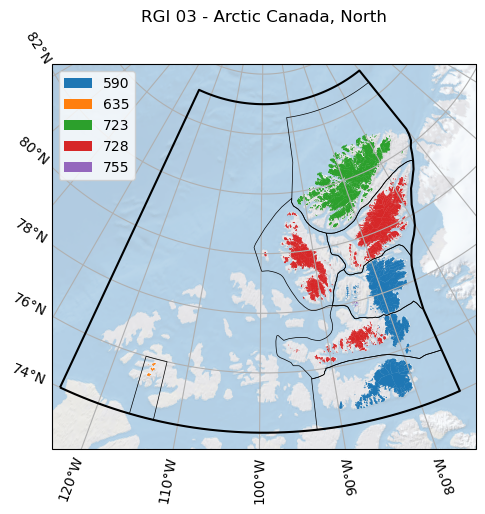

In [64]:
linewidth = 0.2
title = 'RGI 03 - Arctic Canada, North' 
is_rgi6 = False

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=map_crs)
ax.set_extent(extent, crs=ccrs.Geodetic())

gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False, dms=True, 
                  xlocs=np.arange(37) * 10 - 180);
gl.top_labels = False
gl.right_labels = False

# fname = '/home/users/fmaussion/www_fmaussion/misc/rgi7_data/l0_support_data/images/natural-earth-1_large4096px.png'
fname = '/home/users/fmaussion/www_fmaussion/misc/rgi7_data/l0_support_data/images/natural-earth-1_large8192px_white.png'
ax.imshow(imread(fname), origin='upper', transform=ccrs.PlateCarree(), 
          extent=[-180, 180, -90, 90])

rdf.to_crs(map_crs).plot(ax=ax, edgecolor='k', facecolor='none', zorder=3, linewidth=1.5)
srdf.to_crs(map_crs).plot(ax=ax, edgecolor='k', facecolor='none', zorder=2, linewidth=0.5)

handles = []
if is_rgi6:
    for itis in [True, False]:
        ec = '#001fff' if itis else '#ff0000'
        fc = '#465dff' if itis else '#ff4646'
        label = 'Same as RGI6' if itis else 'New in RGI7'
        s_loc = shp_repr.loc[shp_repr['is_rgi6'] == itis]
        if len(s_loc) > 0:
            s_loc.plot(ax=ax, facecolor=fc, edgecolor=ec, linewidth=linewidth, zorder=97)
            area = s_loc['area_km2'].sum()
        else:
            area = 0
        print(f'N={len(s_loc)}, A={area:.1f} km²')
        handles.append(mpatches.Patch(facecolor=ec, label=f'{label}'))
else:
    for i, subid in enumerate(sorted(shp.subm_id.unique().astype(int))):
        fc = f'C{i}'
        ec = fc
        s_loc = shp_repr.loc[shp.subm_id == subid]
        s_loc.plot(ax=ax, facecolor=fc, edgecolor=ec, linewidth=linewidth, zorder=1)
        area = s_loc['area_km2'].sum()
        handles.append(mpatches.Patch(facecolor=fc, label=f'{subid}'))
        print(f'N={len(s_loc)}, A={area:.1f} km²')

# Alternative solution for "Polygon handles not passing to legend"
ax.legend(handles=handles, loc='upper left');
ax.set_title(title);

plot_dir = data_dir + f'/l4_rgi7b0_plots/RGI{reg:02d}'
mkdir(plot_dir)
plotname = 'isrgi6_map' if is_rgi6 else 'inventory_map'
plt.savefig(plot_dir + f'/{plotname}.jpeg', bbox_inches='tight', dpi=300)

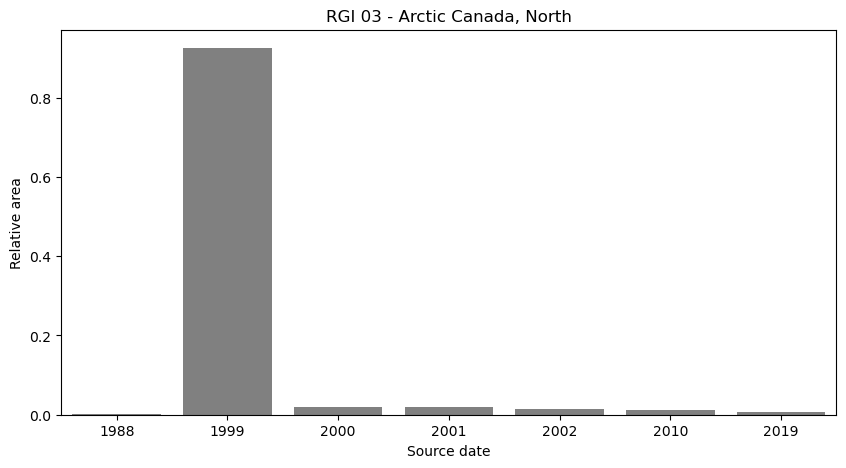

In [61]:
figsize=(10, 5)

f, ax = plt.subplots(figsize=figsize)

date = shp['src_date'].str[:4].astype(int).to_frame('src_date')
date['area'] = shp['area_km2']
date = date.groupby('src_date')['area'].sum().to_frame()
# if reset_index:
#     date = date.reindex(np.arange(date.index.min(), date.index.max()+1, dtype=int), fill_value=0)
date['area'] = date['area'] / date['area'].sum()
date = date.reset_index()

sns.barplot(ax=ax, x='src_date', y='area', data=date, color='grey');
ax.set_ylabel('Relative area'); ax.set_xlabel('Source date'); 
ax.set_title(title);
# plt.xticks(rotation=45, ha='center')

plot_dir = data_dir + f'/l4_rgi7b0_plots/RGI{reg:02d}'
mkdir(plot_dir)
plotname = 'date_hist'
plt.savefig(plot_dir + f'/{plotname}.png', bbox_inches='tight', dpi=300)